##### Copyright 2018 The TensorFlow Hub Authors.

Licensed under the Apache License, Version 2.0 (the "License");

## Fashion MNIST with Keras and TPUs

## Learning objectives

In this Colab, you will learn how to:
*   Code for a standard conv-net that has 3 layers with drop-out and batch normalization between each layer in Keras.
*   Create and compile the model under a distribution strategy in order ot use TPUs.
*   Run a prediction to see how well the model can predict fashion categories and output the result.

## Instructions

<h3>  &nbsp;&nbsp;Train on TPU&nbsp;&nbsp; <a href="https://cloud.google.com/tpu/"><img valign="middle" src="https://raw.githubusercontent.com/GoogleCloudPlatform/tensorflow-without-a-phd/master/tensorflow-rl-pong/images/tpu-hexagon.png" width="50"></a></h3>

1. On the main menu, click Runtime and select **Change runtime type**. Set "TPU" as the hardware accelerator.
1. Click Runtime again and select **Runtime > Run All**. You can also run the cells manually with Shift-ENTER.

TPUs are located in Google Cloud, for optimal performance, they read data directly from Google Cloud Storage (GCS)

## Data, model, and training

Begin by downloading the fashion MNIST dataset using `tf.keras.datasets`, as shown below.

In [ ]:
import tensorflow as tf
import numpy as np
import os
import cv2
from urllib.request import urlopen
import tensorflow_datasets as tfds
import distutils
import matplotlib.pyplot as plt
if distutils.version.LooseVersion(tf.__version__) <= '2.0':
    raise Exception('This notebook is compatible with TensorFlow 1.14 or higher, for TensorFlow 1.13 or lower please use the previous version at https://github.com/tensorflow/tpu/blob/r1.13/tools/colab/fashion_mnist.ipynb')

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

# add empty color dimension
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

<ipython-input-2-604ada5501f7>:9: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if distutils.version.LooseVersion(tf.__version__) <= '2.0':


### Define the model

The following example uses a simple feed-forward network

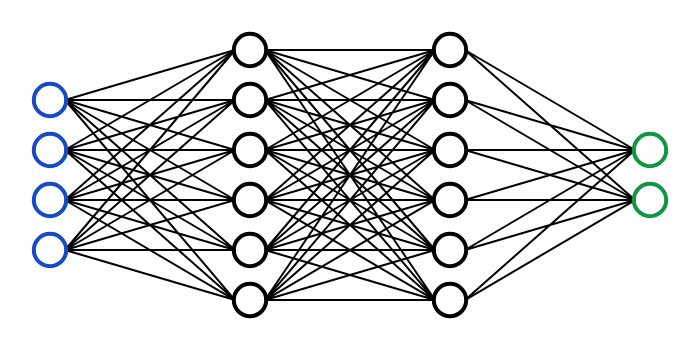

In [ ]:
def create_model():
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(128))
  model.add(tf.keras.layers.Activation('relu'))
  model.add(tf.keras.layers.Dense(128))
  model.add(tf.keras.layers.Activation('relu'))
  model.add(tf.keras.layers.Dense(10))
  model.add(tf.keras.layers.Activation('softmax'))
  return model

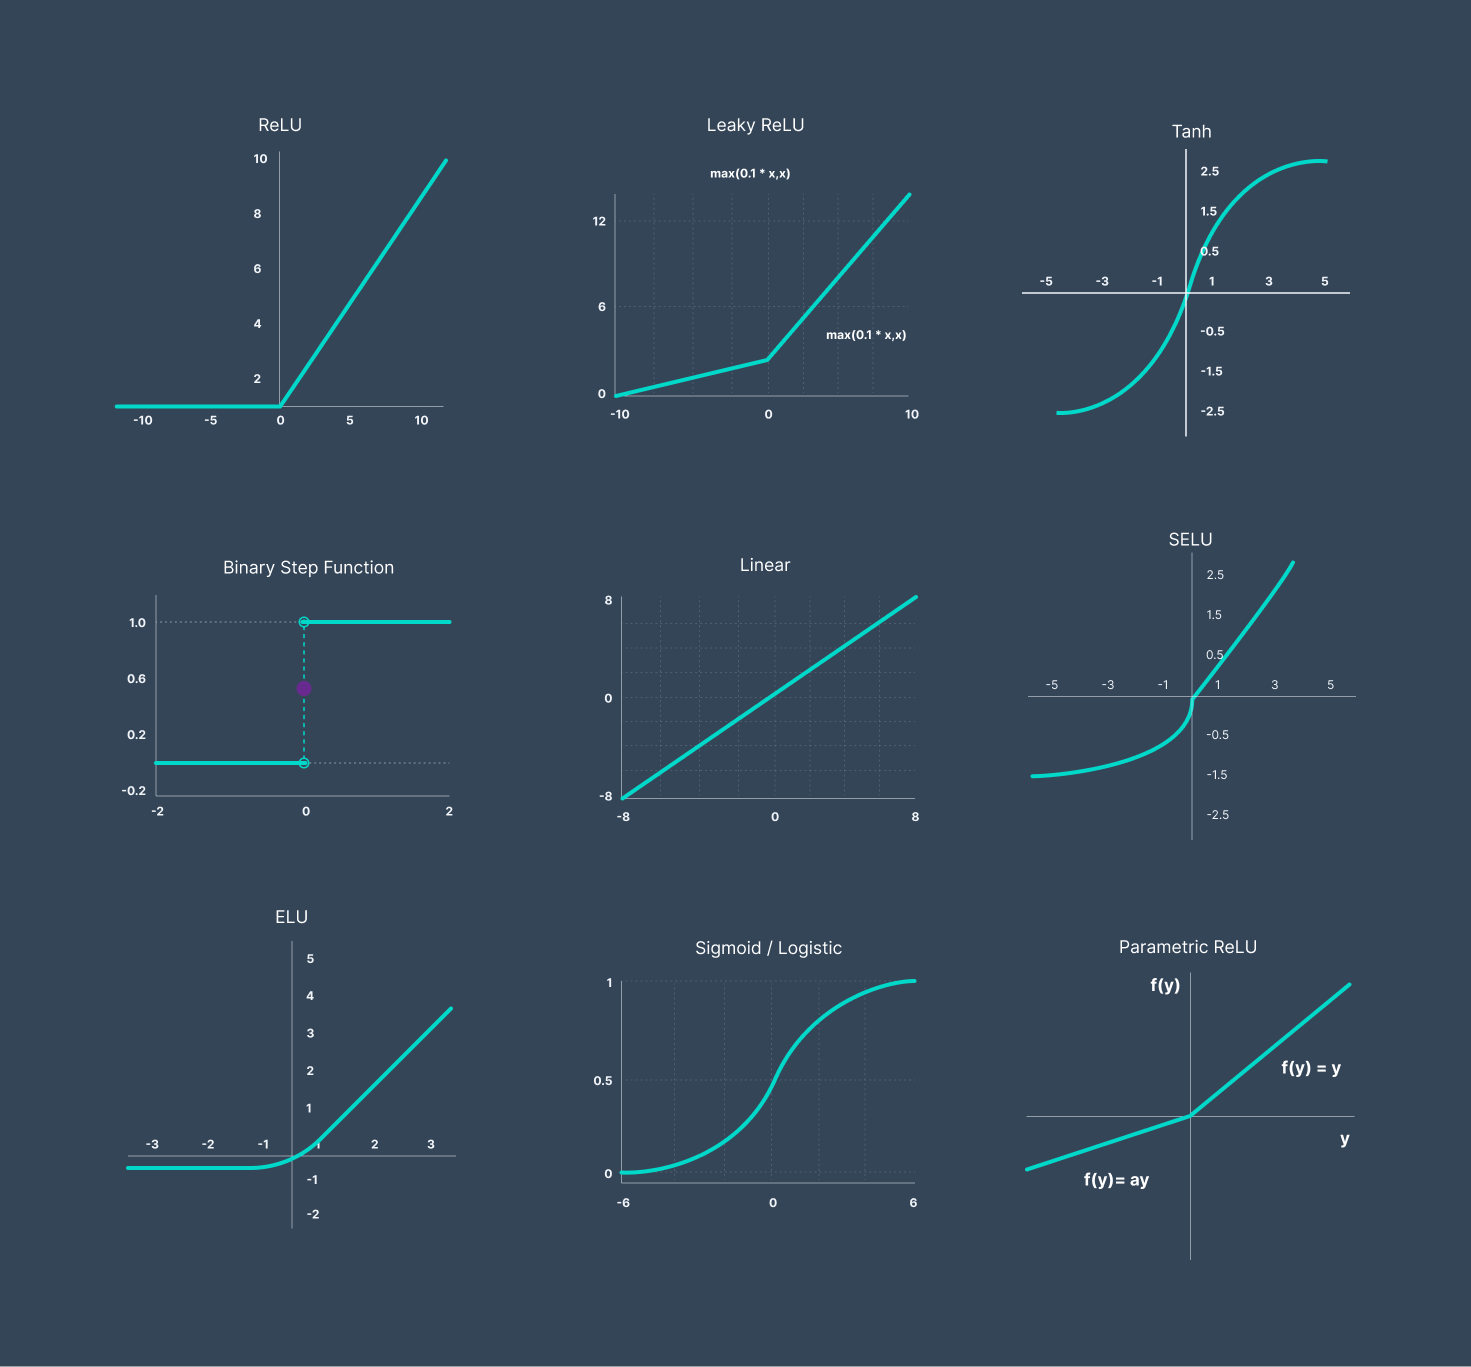

### Train on the TPU

To begin training, construct the model on the TPU and then compile it.

In [ ]:
tf.keras.backend.clear_session()

model = create_model()
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3, ),
    loss='sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy'])

model.fit(
    x_train.astype(np.float32), y_train.astype(np.float32),
    epochs=17, # <--- how many times should we run the model through the training data?
    steps_per_epoch=60,
    validation_data=(x_test.astype(np.float32), y_test.astype(np.float32)),
    validation_freq=17
)

model.save_weights('./fashion_mnist.h5', overwrite=True)

Epoch 1/17
60/60 [==============================] - 6s 45ms/step - loss: 10.6189 - sparse_categorical_accuracy: 0.6555
Epoch 2/17
60/60 [==============================] - 3s 53ms/step - loss: 2.0429 - sparse_categorical_accuracy: 0.7708
Epoch 3/17
60/60 [==============================] - 4s 59ms/step - loss: 1.3616 - sparse_categorical_accuracy: 0.7885
Epoch 4/17
60/60 [==============================] - 4s 64ms/step - loss: 1.0234 - sparse_categorical_accuracy: 0.8014
Epoch 5/17
60/60 [==============================] - 3s 46ms/step - loss: 0.8446 - sparse_categorical_accuracy: 0.8105
Epoch 6/17
60/60 [==============================] - 2s 40ms/step - loss: 0.7268 - sparse_categorical_accuracy: 0.8171
Epoch 7/17
60/60 [==============================] - 3s 45ms/step - loss: 0.6187 - sparse_categorical_accuracy: 0.8280
Epoch 8/17
60/60 [==============================] - 3s 55ms/step - loss: 0.5719 - sparse_categorical_accuracy: 0.8347
Epoch 9/17
60/60 [==============================] - 3s 

### Check the results (inference)

Now that you are done training, see how well the model can predict fashion categories!

(10000, 28, 28, 1)
1/1 [==============================] - 0s 396ms/step


<Figure size 800x800 with 0 Axes>

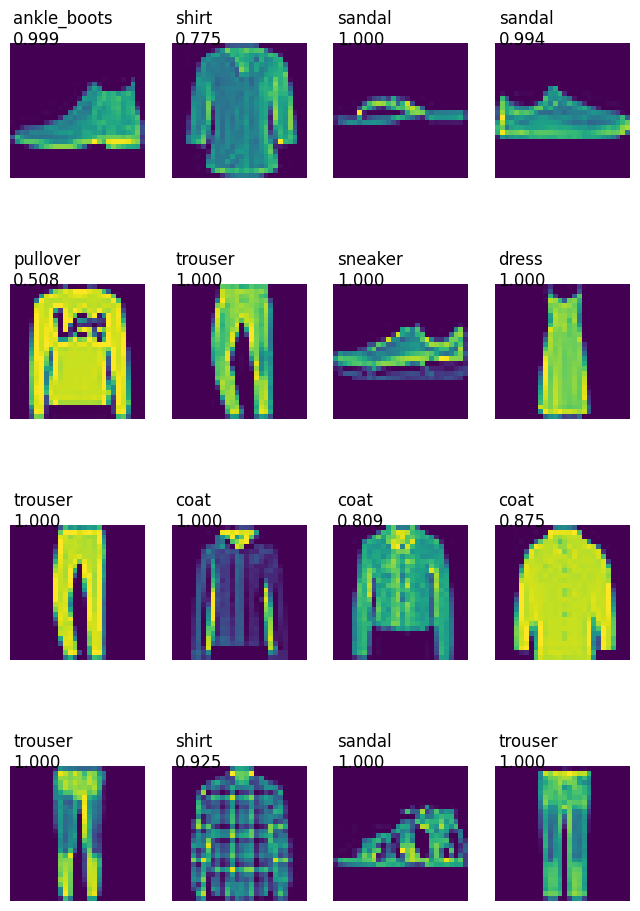

In [ ]:
LABEL_NAMES = ['t_shirt', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle_boots']


from matplotlib import pyplot
%matplotlib inline

def plot_predictions(images, predictions):
  n = images.shape[0]
  nc = int(np.ceil(n / 4))
  f, axes = pyplot.subplots(nc, 4, figsize=(8, 12))
  for i in range(nc * 4):
    y = i // 4
    x = i % 4
    axes[x, y].axis('off')

    label = LABEL_NAMES[np.argmax(predictions[i])]
    confidence = np.max(predictions[i])
    if i > n:
      continue
    axes[x, y].imshow(images[i])
    axes[x, y].text(0.2, -0.2, label + '\n%.3f' % confidence, fontsize=12)
print(x_test.shape)
pyplot.gcf().set_size_inches(8, 8)
predictions = model.predict(x_test[:16])
plot_predictions(np.squeeze(x_test[:16]), predictions)
pyplot.show()

Without Any Preprocessing (Except shrinking image to 28 x 28 and switching to Grayscale)

(1, 28, 28, 1)
1/1 [==============================] - 0s 70ms/step
100.0% chance of being a bag


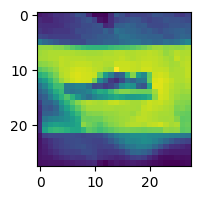

In [ ]:
og_image = urlopen("https://i.imgur.com/NBbzfpQ.jpg")
og_image = np.asarray(bytearray(og_image.read()), dtype="uint8")
og_image = cv2.imdecode(og_image, cv2.IMREAD_COLOR)
og_image = cv2.resize(og_image, (28, 28), interpolation=cv2.INTER_AREA)
og_image = cv2.cvtColor(og_image, cv2.COLOR_BGR2GRAY)
plt.figure(figsize=(2,2))
plt.imshow(og_image)
og_image = np.expand_dims(og_image, axis=0)
og_image = np.expand_dims(og_image, axis=-1)
print(og_image.shape)
prediction = model.predict(og_image)
prediction_label = LABEL_NAMES[np.argmax(prediction)]
print(f"{np.max(prediction) * 100}% chance of being a {prediction_label}")
#print percent chance

With Preprocessing using OpenCV to Crop and Binarize Image

(1, 28, 28, 1)
1/1 [==============================] - 0s 22ms/step
99.99994039535522% chance of being a sandal


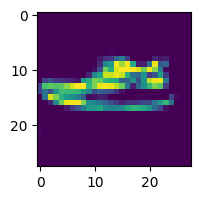

In [ ]:
image_response = urlopen("https://i.imgur.com/PwvB2Lh.png")
processed_image = np.asarray(bytearray(image_response.read()), dtype="uint8")
processed_image = cv2.imdecode(processed_image, cv2.IMREAD_GRAYSCALE)
plt.figure(figsize=(2,2))
plt.imshow(processed_image)
processed_image = np.expand_dims(processed_image, axis=0)
processed_image = np.expand_dims(processed_image, axis=-1)
print(processed_image.shape)
prediction = model.predict(processed_image)
prediction_label = LABEL_NAMES[np.argmax(prediction)]
print(f"{np.max(prediction) * 100}% chance of being a {prediction_label}")

## Potential Optimizations

The model we used is extremely simple, and was trained for less than two minutes. Using a more complex convolutional structure, (shown below), and training on more data for more time, we were able to get to 99.5% accuracy on this dataset. Feel free to ask on Discord about ways to take this further, and stay tuned for a more advanced machine learning workshop in the future...

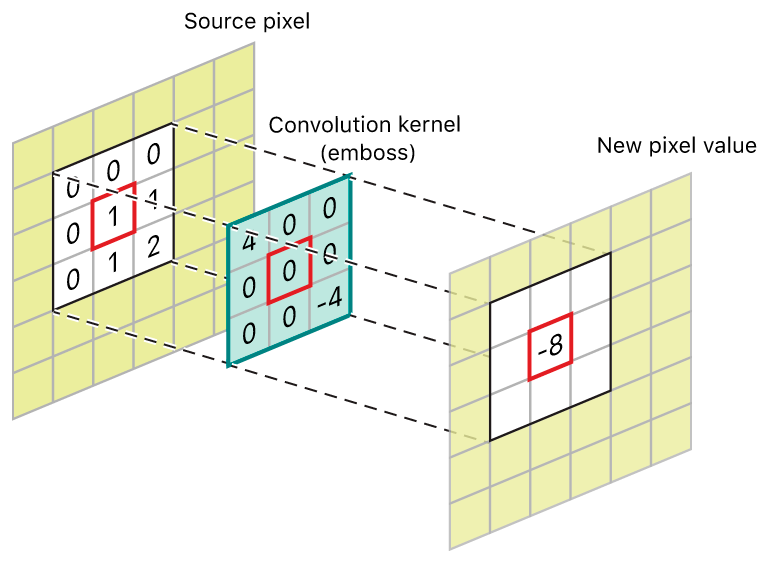

In [ ]:
def create_model_improved():
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.BatchNormalization(input_shape=x_train.shape[1:]))
  model.add(tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation='elu'))
  model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
  model.add(tf.keras.layers.Dropout(0.25))

  model.add(tf.keras.layers.BatchNormalization(input_shape=x_train.shape[1:]))
  model.add(tf.keras.layers.Conv2D(128, (5, 5), padding='same', activation='elu'))
  model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
  model.add(tf.keras.layers.Dropout(0.25))

  model.add(tf.keras.layers.BatchNormalization(input_shape=x_train.shape[1:]))
  model.add(tf.keras.layers.Conv2D(256, (5, 5), padding='same', activation='elu'))
  model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
  model.add(tf.keras.layers.Dropout(0.25))

  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(256))
  model.add(tf.keras.layers.Activation('elu'))
  model.add(tf.keras.layers.Dropout(0.5))
  model.add(tf.keras.layers.Dense(10))
  model.add(tf.keras.layers.Activation('softmax'))
  return model

In [ ]:
fancy_model = create_model_improved()
fancy_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 28, 28, 1)        4         
 ormalization)                                                   
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 64)        1664      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 14, 14, 64)       256       
 hNormalization)                                                 
                                                      

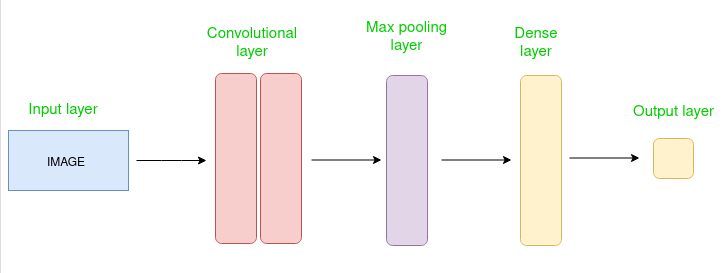

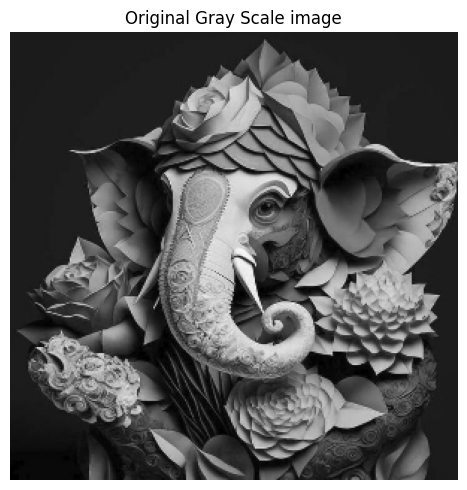

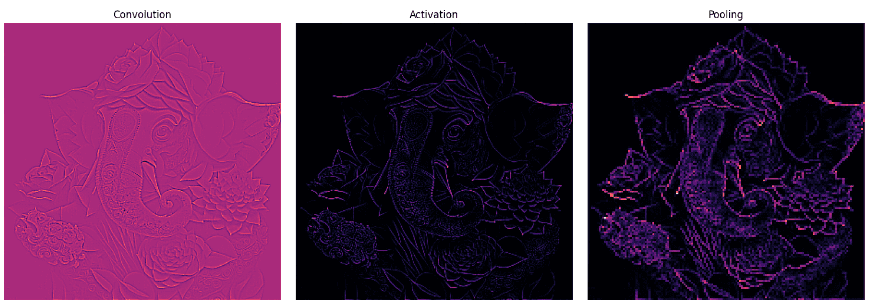

In [ ]:
tf.keras.backend.clear_session()

resolver = tf.distribute.cluster_resolver.TPUClusterResolver('grpc://' + os.environ['COLAB_TPU_ADDR'])
tf.config.experimental_connect_to_cluster(resolver)

# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))

strategy = tf.distribute.experimental.TPUStrategy(resolver)

with strategy.scope():
  cnn_model = create_model_improved()
  cnn_model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3, ),
      loss='sparse_categorical_crossentropy',
      metrics=['sparse_categorical_accuracy'])

cnn_model.fit(
    x_train.astype(np.float32), y_train.astype(np.float32),
    epochs=17, # <--- how many times should we run the model through the training data?
    steps_per_epoch=60,
    validation_data=(x_test.astype(np.float32), y_test.astype(np.float32)),
    validation_freq=17
)

cnn_model.save_weights('./fashion_mnist.h5', overwrite=True)

All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU')]
Epoch 1/17
60/60 [==============================] - 5s 22ms/step - loss: 1.0037 - sparse_categorical_accuracy: 0.7007
Epoch 2/17
60/60 [==============================] - 1s 22ms/step - loss: 0.5161 - sparse_categorical_accuracy: 0.8243
Epoch 3/17
60/60 [==============================] - 1s 21ms/step - loss: 0.42

(1, 28, 28, 1)
1/1 [==============================] - 1s 1s/step
85.46540141105652% chance of being a sneaker


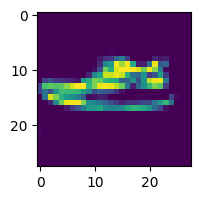

In [ ]:
image_response = urlopen("https://i.imgur.com/PwvB2Lh.png")
processed_image = np.asarray(bytearray(image_response.read()), dtype="uint8")
processed_image = cv2.imdecode(processed_image, cv2.IMREAD_GRAYSCALE)
plt.figure(figsize=(2,2))
plt.imshow(processed_image)
processed_image = np.expand_dims(processed_image, axis=0)
processed_image = np.expand_dims(processed_image, axis=-1)
print(processed_image.shape)
prediction = cnn_model.predict(processed_image)
prediction_label = LABEL_NAMES[np.argmax(prediction)]
print(f"{np.max(prediction) * 100}% chance of being a {prediction_label}")

Advantages of Convolutional Neural Networks (CNNs):
- Good at detecting patterns and features in images, videos, and audio signals.
- Robust to translation, rotation, and scaling invariance.
- End-to-end training, no need for manual feature extraction.
- Can handle large amounts of data and achieve high accuracy.

Disadvantages of Convolutional Neural Networks (CNNs):
- Computationally expensive to train and require a lot of memory.
- Can be prone to overfitting if not enough data or proper regularization is used.
- Requires large amounts of labeled data.
- Interpretability is limited, it's hard to understand what the network has learned.


## What's next

* Learn more about [Convolutional Neural Networks](https://saturncloud.io/blog/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way/)
* Learn about [Cloud TPUs](https://cloud.google.com/tpu/docs) on Google Cloud
* Explore the range of [Cloud TPU tutorials and Colabs](https://cloud.google.com/tpu/docs/tutorials) to find other examples that can be used when implementing your ML project.

On Google Cloud Platform, in addition to GPUs and TPUs available on pre-configured [deep learning VMs](https://cloud.google.com/deep-learning-vm/),  you will find [AutoML](https://cloud.google.com/automl/)*(beta)* for training custom models without writing code and [Cloud ML Engine](https://cloud.google.com/ml-engine/docs/) which will allows you to run parallel trainings and hyperparameter tuning of your custom models on distributed hardware.
